## Problem Statement:
You are a cab rental start-up company. You have successfully run the pilot project and now want to launch your cab service across the country. You have collected the historical data from your pilot project and now have a requirement to apply analytics for fare prediction. You need to design a system that predicts the fare amount for a cab ride in the city.

In [86]:
import pandas_profiling
import pandas as pd
from fancyimpute import KNN
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.externals import joblib

In [87]:
train_df = pd.read_csv("train_cab/train_cab.csv")
#profile = train_df.profile_report(title="Cab Fare Prediction Profiling Report", plot = {'histogram':{'bins':50}})
#profile.to_file("CabFarePredictionReport.html")

In [88]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1.0


In [89]:
test_df = pd.read_csv("test/test.csv")
test_df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [90]:
train_df.shape, test_df.shape

((16067, 7), (9914, 6))

# Exploratory Data Analysis

In [91]:
#Check for the data types of the training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB


The datatypes of fare_amount and pickup_datetime fields are of type object. <b>fare_amount</b> is a continous variable and requires conversion from object. <b>pickup_datetime</b> can be converted into Date format. <b>passenger_count</b> is a discrete variable and can be converted to integer. Let us find the sum of all the nulls in each column


In [92]:
for col in train_df.columns:
    print("The number of NAs in {0} is {1}".format(col,train_df[col].isnull().sum()))

The number of NAs in fare_amount is 24
The number of NAs in pickup_datetime is 0
The number of NAs in pickup_longitude is 0
The number of NAs in pickup_latitude is 0
The number of NAs in dropoff_longitude is 0
The number of NAs in dropoff_latitude is 0
The number of NAs in passenger_count is 55


In [93]:
#Check for the data types of the testing data
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9914 non-null object
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: float64(4), int64(1), object(1)
memory usage: 464.8+ KB


In [94]:
for col in test_df.columns:
    print("The number of NAs in {0} is {1}".format(col,test_df[col].isnull().sum()))

The number of NAs in pickup_datetime is 0
The number of NAs in pickup_longitude is 0
The number of NAs in pickup_latitude is 0
The number of NAs in dropoff_longitude is 0
The number of NAs in dropoff_latitude is 0
The number of NAs in passenger_count is 0


<b>pickup_datetime</b> can be converted into Date format

In [95]:
df_train = train_df.copy()
#train_df = df_train.copy

In [96]:
train_df['fare_amount'] = pd.to_numeric(train_df['fare_amount'], errors='coerce')

In [97]:
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], errors='coerce')

In [98]:
#Find the data where it resulted datetime conversion error
train_df['pickup_datetime'][train_df['pickup_datetime'].isnull()]

1327   NaT
Name: pickup_datetime, dtype: datetime64[ns]

In [99]:
train_df.iloc[1327]

fare_amount             11.5
pickup_datetime          NaT
pickup_longitude    -73.9819
pickup_latitude      40.7282
dropoff_longitude   -73.9886
dropoff_latitude     40.7592
passenger_count            1
Name: 1327, dtype: object

Due to the incorrect recording for the datetime value, we will drop this single observation else we needed to do an imputation for this variable

In [100]:
#dropping NA value in pickup_datetime
train_df = train_df.drop(train_df[train_df['pickup_datetime'].isnull()].index, axis = 0)

Also there are some incorrect incorrect entries in the coordinates(latitude/longitude). I am going to delete those data since they are affecting the modelling

In [101]:
train_df = train_df[(train_df.pickup_longitude != 0) & (train_df.pickup_latitude != 0) & (train_df.dropoff_longitude != 0) & (train_df.dropoff_latitude != 0)]

Also there are entries where pickup and dropoff coordinates are same. This could be a roundtrip or the cab was booked and again it got cancelled

In [102]:
train_df[(train_df.pickup_longitude == train_df.dropoff_longitude) & (train_df.pickup_latitude == train_df.dropoff_latitude)].shape

(156, 7)

There were <b>156</b> such instances where the cab ride could be roundtrip or cancelled. I am ignoring those instances in my dataset

In [103]:
train_df = train_df[(train_df.pickup_longitude != train_df.dropoff_longitude) & (train_df.pickup_latitude != train_df.dropoff_latitude)]

In [104]:
test_df[(test_df.pickup_longitude == test_df.dropoff_longitude) & (test_df.pickup_latitude == test_df.dropoff_latitude)].shape

(85, 6)

There are similar cases of around <b>85</b> in the scoring dataset

In [105]:
test_df = test_df[(test_df.pickup_longitude != test_df.dropoff_longitude) & (test_df.pickup_latitude != test_df.dropoff_latitude)]

There is one particular case where the <b>pickup_latitude</b> > 90. Ignoring this case

In [106]:
train_df[(train_df['pickup_latitude'] > 90) | (train_df['pickup_latitude'] < -90)]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
5686,3.3,2011-07-30 11:15:00,-73.947235,401.083332,-73.951392,40.778927,1.0


In [107]:
train_df.drop(train_df[(train_df['pickup_latitude'] > 90) | (train_df['pickup_latitude'] < -90)].index, inplace = True)

In [108]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15579 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          15556 non-null float64
pickup_datetime      15579 non-null datetime64[ns]
pickup_longitude     15579 non-null float64
pickup_latitude      15579 non-null float64
dropoff_longitude    15579 non-null float64
dropoff_latitude     15579 non-null float64
passenger_count      15524 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 973.7 KB


In [109]:
df_test = test_df.copy()
test_df['pickup_datetime'] = pd.to_datetime(test_df['pickup_datetime'])

In [110]:
test_df["passenger_count"] = test_df["passenger_count"].astype(int)

In [111]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9828 entries, 0 to 9913
Data columns (total 6 columns):
pickup_datetime      9828 non-null datetime64[ns]
pickup_longitude     9828 non-null float64
pickup_latitude      9828 non-null float64
dropoff_longitude    9828 non-null float64
dropoff_latitude     9828 non-null float64
passenger_count      9828 non-null int32
dtypes: datetime64[ns](1), float64(4), int32(1)
memory usage: 499.1 KB


Note: We will convert the <b>passenger_count</b> to int in the training set after converting the missing values within that variable

# Feature Extraction

Lets extract the <b>pickup_datetime</b> into different features

In [27]:
train_df['year'] = train_df['pickup_datetime'].dt.year
train_df['month'] = train_df['pickup_datetime'].dt.month
train_df['day'] = train_df['pickup_datetime'].dt.day
train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek
train_df['hour'] = train_df['pickup_datetime'].dt.hour
train_df['minute'] = train_df['pickup_datetime'].dt.minute
train_df['second'] = train_df['pickup_datetime'].dt.second

train_df = train_df.drop('pickup_datetime', axis = 1)
train_df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,minute,second
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,15,0,17,26,21
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,5,1,16,52,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,18,3,0,35,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,21,5,4,30,42
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,9,1,7,51,0


In [28]:
test_df['year'] = test_df['pickup_datetime'].dt.year
test_df['month'] = test_df['pickup_datetime'].dt.month
test_df['day'] = test_df['pickup_datetime'].dt.day
test_df['dayofweek'] = test_df['pickup_datetime'].dt.dayofweek
test_df['hour'] = test_df['pickup_datetime'].dt.hour
test_df['minute'] = test_df['pickup_datetime'].dt.minute
test_df['second'] = test_df['pickup_datetime'].dt.second

test_df = test_df.drop('pickup_datetime', axis = 1)
test_df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,minute,second
0,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,27,1,13,8,24
1,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,27,1,13,8,24
2,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,8,5,11,53,44
3,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,1,5,21,12,12
4,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,1,5,21,12,12


In [29]:
train_df.describe(include = 'all')

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,minute,second
count,15556.000000,15579.000000,15579.000000,15579.000000,15579.000000,15524.000000,15579.000000,15579.000000,15579.000000,15579.000000,15579.000000,15579.000000,15579.000000
mean,15.125799,-73.911560,40.689217,-73.906325,40.687152,2.640210,2011.738558,6.268567,15.668721,3.034919,13.505296,29.654663,16.182618
std,437.125856,2.665992,2.620141,2.717914,2.639286,61.762731,1.868101,3.448541,8.683724,1.969777,6.508171,17.294965,19.478302
min,-3.000000,-74.438233,-74.006893,-74.227047,-74.006377,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-73.992402,40.736562,-73.991374,40.736274,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,15.000000,0.000000
50%,8.500000,-73.982077,40.753320,-73.980572,40.754246,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,30.000000,5.000000
75%,12.500000,-73.968187,40.767799,-73.965512,40.768311,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,45.000000,32.000000
max,54343.000000,40.766125,41.366138,40.802437,41.366138,5345.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,59.000000,59.000000


In [30]:
test_df.describe(include='all')

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,dayofweek,hour,minute,second
count,9828.000000,9828.000000,9828.000000,9828.000000,9828.000000,9828.000000,9828.000000,9828.000000,9828.000000,9828.000000,9828.000000,9828.000000
mean,-73.975177,40.750776,-73.974102,40.751484,1.670737,2011.821429,6.854599,16.193630,2.852971,13.466015,29.569699,16.652930
std,0.039233,0.031166,0.035137,0.033219,1.278327,1.804746,3.353396,8.837788,1.994664,6.874573,18.674460,19.592415
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,-73.992570,40.736072,-73.991277,40.735195,1.000000,2010.000000,4.000000,9.000000,1.000000,8.000000,13.000000,0.000000
50%,-73.982366,40.753044,-73.980085,40.754054,1.000000,2012.000000,7.000000,16.000000,3.000000,15.000000,33.000000,7.000000
75%,-73.968171,40.767042,-73.964287,40.768747,2.000000,2014.000000,10.000000,25.000000,5.000000,19.000000,45.000000,33.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,59.000000,59.000000


In [31]:
from geopy.distance import vincenty

def calculate_distance(row):
    coords_1 = (row['pickup_latitude'], row['pickup_longitude'])
    coords_2 = (row['dropoff_latitude'], row['dropoff_longitude'])
    return vincenty(coords_1, coords_2).miles

Let us remove those datapoints where one of the latitudes or longitudes are recorded as 0

In [32]:
train_df["distance"] = train_df.apply(calculate_distance, axis = 1)
test_df["distance"] = test_df.apply(calculate_distance, axis = 1)

C:\Users\gautam_pai\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


In [33]:
train_df = train_df.drop(['pickup_latitude','pickup_longitude','dropoff_longitude','dropoff_latitude'], axis = 1)
test_df = test_df.drop(['pickup_latitude','pickup_longitude','dropoff_longitude','dropoff_latitude'], axis = 1)

<b>Imputation Important</b>

Before doing any imputation we need to first split the data into train and test and imputation statistics has to be done on the train set and the same has to be propagated to test set to avoid leakage

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X = train_df.iloc[:,1:]
y = train_df.iloc[:,0:1]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

# Missing Value Analysis

In [37]:
print("The missing value percentage in train data is:")
pd.DataFrame(train_df.isnull().mean()*100, columns = ['percentage']).reset_index().sort_values('percentage', ascending=False)


The missing value percentage in train data is:


,index,percentage
1,passenger_count,0.353039
0,fare_amount,0.147635
2,year,0.000000
3,month,0.000000
4,day,0.000000
5,dayofweek,0.000000
6,hour,0.000000
7,minute,0.000000
8,second,0.000000
9,distance,0.000000


In [38]:
print("The missing value percentage in test data is:")
pd.DataFrame(test_df.isnull().mean()*100, columns = ['percentage']).reset_index().sort_values('percentage', ascending=False)


The missing value percentage in test data is:


,index,percentage
0,passenger_count,0.0
1,year,0.0
2,month,0.0
3,day,0.0
4,dayofweek,0.0
5,hour,0.0
6,minute,0.0
7,second,0.0
8,distance,0.0


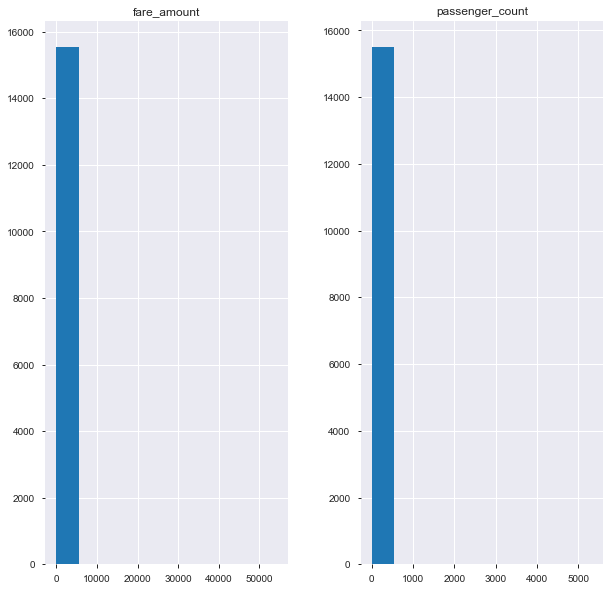

In [39]:
train_df[["passenger_count","fare_amount"]].hist(figsize=(10,10))
plt.show()

We see a similar distribution for both the variables <b>fare_amount</b> and <b>passenger_count</b>.We select an imputation technique so that there is no change in the variance. Since the distribution is skewed, imputing with mean/median does not much change the variance of the existing records without nulls. Lets try out few imputation techniques below

In [40]:
print("Variance of the fare_amount is: ", y_train['fare_amount'].dropna().var())

Variance of the fare_amount is:  272960.1178291612


In [41]:
print("Variance of the passenger_count is: ",X_train['passenger_count'].dropna().var())

Variance of the passenger_count is:  2781.4612445201496


<b>Imputation by Mean </b>

In [42]:
mean = y_train['fare_amount'].mean()
print("Mean is", mean)
print("Variance of the fare_amount after mean imputation is: ", y_train['fare_amount'].fillna(mean).var())

mean = X_train['passenger_count'].mean()
print("Mean is", mean)
print("Variance of the passenger_count after mean imputation is: ", X_train['passenger_count'].fillna(mean).var())

Mean is 16.66348916238054
Variance of the fare_amount after mean imputation is:  272534.55638353614
Mean is 2.471634287818801
Variance of the passenger_count after mean imputation is:  2770.2374463947936


<b>Imputation by Median</b>

In [43]:
median = y_train['fare_amount'].median()
print("Median is", median)
print("Variance of the fare_amount after median imputation is: ", y_train['fare_amount'].fillna(median).var())

median = X_train['passenger_count'].median()
print("Median is", median)
print("Variance of the passenger_count after median imputation is: ", X_train['passenger_count'].fillna(median).var())

Median is 8.5
Variance of the fare_amount after median imputation is:  272534.6601213614
Median is 1.0
Variance of the passenger_count after median imputation is:  2770.246150232422


<b>KNN Imputation</b>

In [44]:
imputed_data_Xtrain = pd.DataFrame(KNN(k = 5).fit_transform(X_train), columns = X_train.columns)
imputed_data_ytrain = pd.DataFrame(KNN(k = 5).fit_transform(y_train), columns = y_train.columns)

Imputing row 1/10905 with 0 missing, elapsed time: 78.099
Imputing row 101/10905 with 0 missing, elapsed time: 78.100
Imputing row 201/10905 with 0 missing, elapsed time: 78.101
Imputing row 301/10905 with 0 missing, elapsed time: 78.104
Imputing row 401/10905 with 0 missing, elapsed time: 78.106
Imputing row 501/10905 with 0 missing, elapsed time: 78.108
Imputing row 601/10905 with 0 missing, elapsed time: 78.109
Imputing row 701/10905 with 0 missing, elapsed time: 78.111
Imputing row 801/10905 with 0 missing, elapsed time: 78.112
Imputing row 901/10905 with 0 missing, elapsed time: 78.115
Imputing row 1001/10905 with 1 missing, elapsed time: 78.115
Imputing row 1101/10905 with 0 missing, elapsed time: 78.118
Imputing row 1201/10905 with 0 missing, elapsed time: 78.119
Imputing row 1301/10905 with 0 missing, elapsed time: 78.121
Imputing row 1401/10905 with 0 missing, elapsed time: 78.122
Imputing row 1501/10905 with 0 missing, elapsed time: 78.123
Imputing row 1601/10905 with 0 missi

[KNN] Warning: 17/10905 still missing after imputation, replacing with 0


In [45]:
print("Variance of passenger_count after imputation by KNN", imputed_data_Xtrain['passenger_count'].var())
print("Variance of fare_amount after imputation by KNN", imputed_data_ytrain['fare_amount'].var())

Variance of passenger_count after imputation by KNN 2770.2421889438683
Variance of fare_amount after imputation by KNN 272534.98861599836


<b> Imputation by tail end of the distribution </b>

Here we impute by values at the tail end of the distribution <br>
$ value = \mu \pm (some constant) * \sigma $

In [46]:
#We will select the constant as 1 above and verify the variance
fare_amount_to_impute = round(y_train['fare_amount'].mean() + y_train['fare_amount'].std())
print("Variance of fare_amount after tail end imputation", y_train['fare_amount'].fillna(fare_amount_to_impute).var())

passenger_count_to_impute = round(X_train['passenger_count'].mean() + X_train['passenger_count'].std())
print("Variance of passenger_amount after tail end imputation", X_train['passenger_count'].fillna(passenger_count_to_impute).var())

Variance of fare_amount after tail end imputation 272959.26032175793
Variance of passenger_amount after tail end imputation 2781.3266090951543


*We will hence select the tail end of the impuation technique*

In [47]:
y_train['fare_amount'].fillna(fare_amount_to_impute, inplace=True)
X_train['passenger_count'].fillna(passenger_count_to_impute, inplace = True)

C:\Users\gautam_pai\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Impute the same statistics on the test data

In [48]:
y_test['fare_amount'].fillna(fare_amount_to_impute, inplace=True)
X_test['passenger_count'].fillna(passenger_count_to_impute, inplace = True)

C:\Users\gautam_pai\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


We can now convert the <b>passenger_count</b> to integer

In [49]:
X_train['passenger_count'] = X_train['passenger_count'].astype(int)
X_test['passenger_count'] = X_test['passenger_count'].astype(int)

C:\Users\gautam_pai\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\gautam_pai\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [50]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10905 entries, 13320 to 14546
Data columns (total 9 columns):
passenger_count    10905 non-null int32
year               10905 non-null int64
month              10905 non-null int64
day                10905 non-null int64
dayofweek          10905 non-null int64
hour               10905 non-null int64
minute             10905 non-null int64
second             10905 non-null int64
distance           10905 non-null float64
dtypes: float64(1), int32(1), int64(7)
memory usage: 809.4 KB


In [51]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
passenger_count,10905.0,2.683540,52.738285,0.000000,1.000000,1.000000,2.000000,5345.000000
year,10905.0,2011.751123,1.862982,2009.000000,2010.000000,2012.000000,2013.000000,2015.000000
month,10905.0,6.285007,3.450549,1.000000,3.000000,6.000000,9.000000,12.000000
day,10905.0,15.689592,8.672732,1.000000,8.000000,16.000000,23.000000,31.000000
dayofweek,10905.0,3.038698,1.966700,0.000000,1.000000,3.000000,5.000000,6.000000
hour,10905.0,13.499037,6.509096,0.000000,9.000000,14.000000,19.000000,23.000000
minute,10905.0,29.699771,17.293274,0.000000,15.000000,30.000000,45.000000,59.000000
second,10905.0,16.017790,19.386752,0.000000,0.000000,5.000000,32.000000,59.000000
distance,10905.0,2.429198,32.445315,0.000126,0.788183,1.352515,2.414433,3377.012556


In [52]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4674 entries, 15519 to 3684
Data columns (total 9 columns):
passenger_count    4674 non-null int32
year               4674 non-null int64
month              4674 non-null int64
day                4674 non-null int64
dayofweek          4674 non-null int64
hour               4674 non-null int64
minute             4674 non-null int64
second             4674 non-null int64
distance           4674 non-null float64
dtypes: float64(1), int32(1), int64(7)
memory usage: 346.9 KB


In [53]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
passenger_count,4674.0,3.155113,78.826600,0.00000,1.000000,1.000000,2.000000,5334.000000
year,4674.0,2011.709243,1.879864,2009.00000,2010.000000,2012.000000,2013.000000,2015.000000
month,4674.0,6.230210,3.443913,1.00000,3.000000,6.000000,9.000000,12.000000
day,4674.0,15.620026,8.710052,1.00000,8.000000,16.000000,23.000000,31.000000
dayofweek,4674.0,3.026102,1.977122,0.00000,1.000000,3.000000,5.000000,6.000000
hour,4674.0,13.519897,6.506686,0.00000,9.000000,14.000000,19.000000,23.000000
minute,4674.0,29.549422,17.300303,0.00000,15.000000,30.000000,44.000000,59.000000
second,4674.0,16.567180,19.686965,0.00000,0.000000,6.000000,33.000000,59.000000
distance,4674.0,2.765941,40.321517,0.00049,0.808562,1.389928,2.511762,2752.152328


In [54]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10905 entries, 13320 to 14546
Data columns (total 1 columns):
fare_amount    10905 non-null float64
dtypes: float64(1)
memory usage: 170.4 KB


In [55]:
y_train.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,10905.0,17.477769,522.455032,-3.0,6.0,8.5,12.5,54343.0


In [56]:
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4674 entries, 15519 to 3684
Data columns (total 1 columns):
fare_amount    4674 non-null float64
dtypes: float64(1)
memory usage: 73.0 KB


In [57]:
y_test.describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,4674.0,12.216273,21.19181,2.5,6.1,8.5,12.9,539.0


***Plotting boxplot & distplot in train dataset***

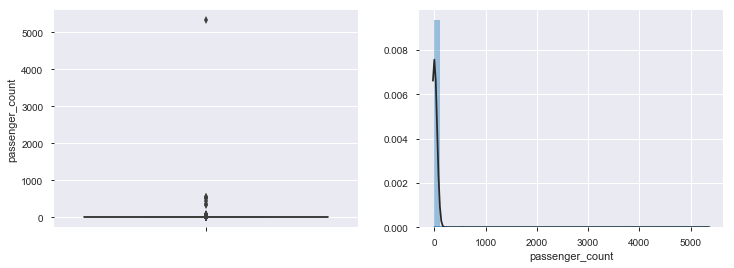

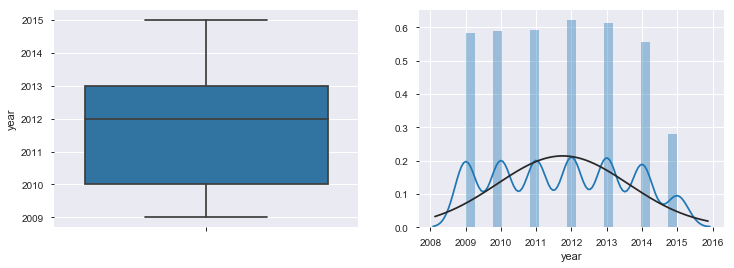

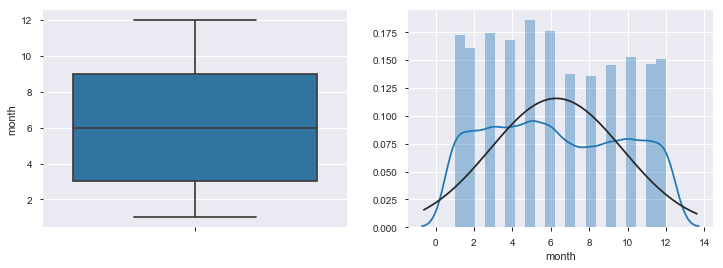

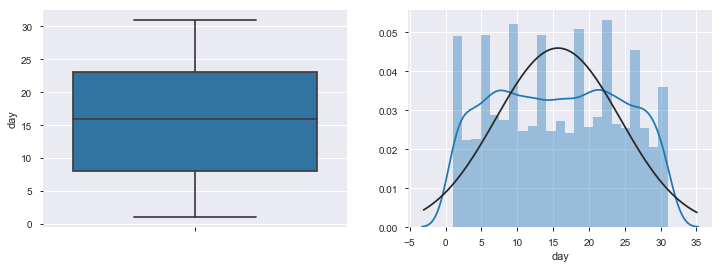

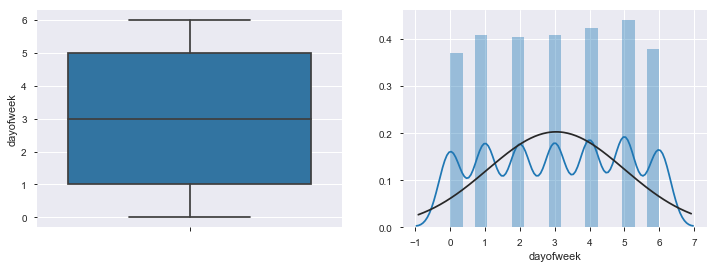

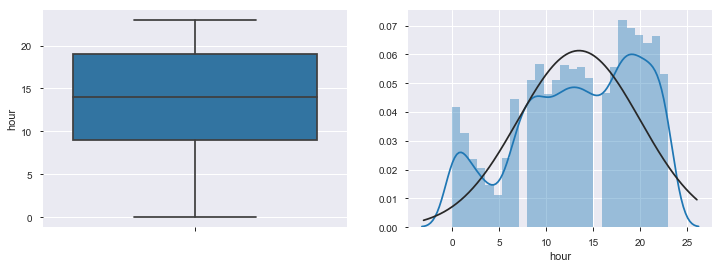

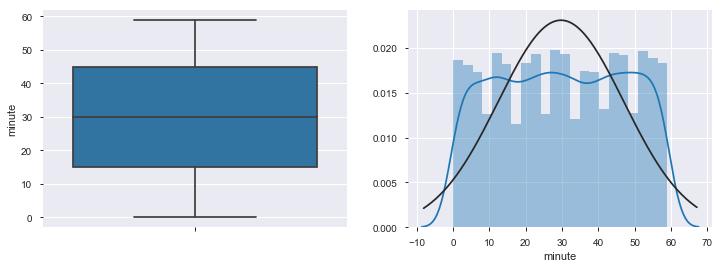

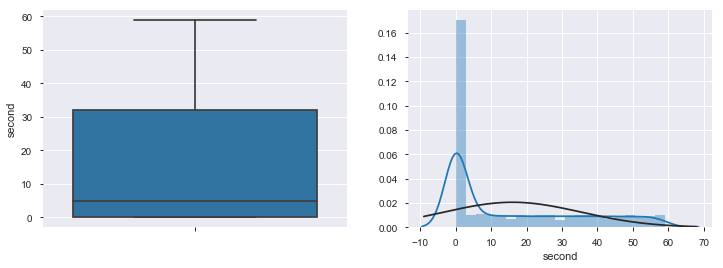

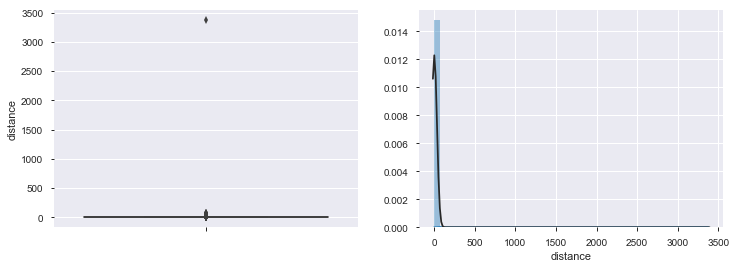

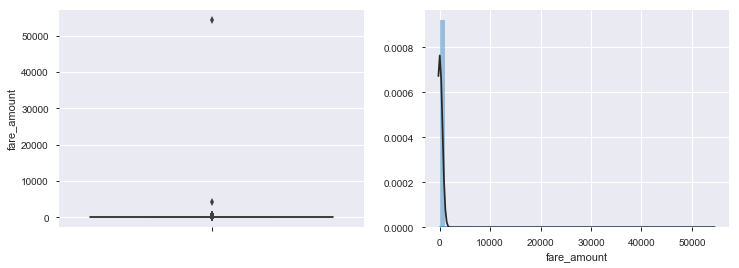

In [58]:
for col in X_train.columns:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    sns.boxplot(data=X_train,y=col,ax=ax)
    ax = fig.add_subplot(122)
    sns.distplot(X_train[col],kde=True,ax=ax, fit=stats.norm)

#Plotting the y_train data
for col in y_train.columns:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    sns.boxplot(data=y_train, y = col, ax=ax)
    ax = fig.add_subplot(122)
    sns.distplot(y_train[col], kde=True, ax=ax, fit=stats.norm)

***Plotting boxplot and distplot in test dataset***

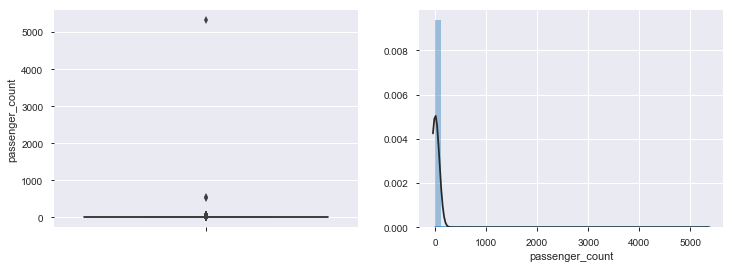

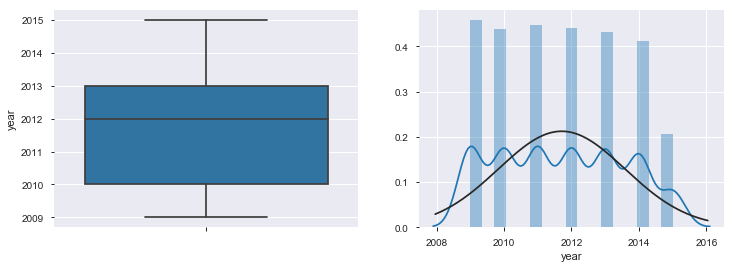

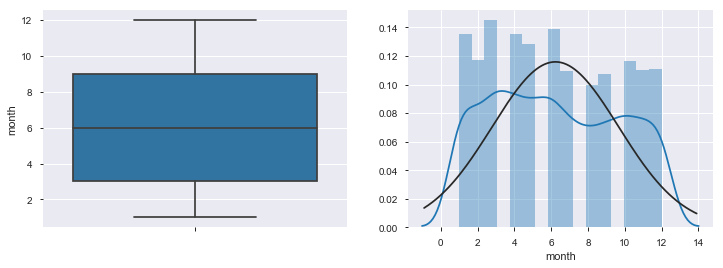

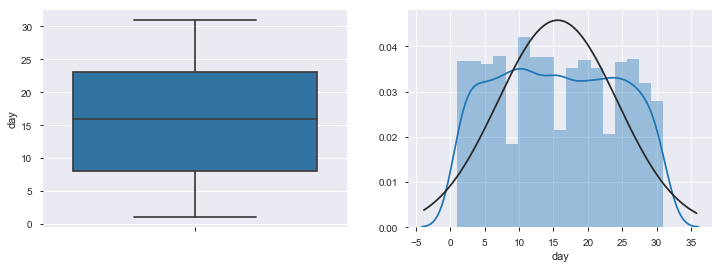

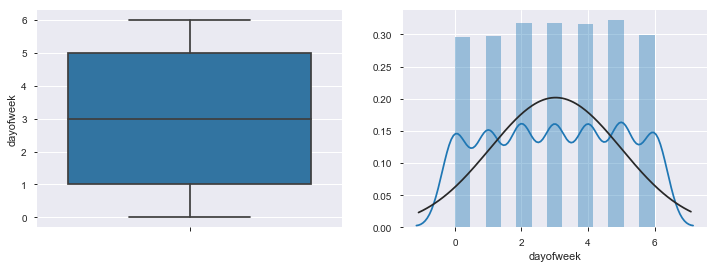

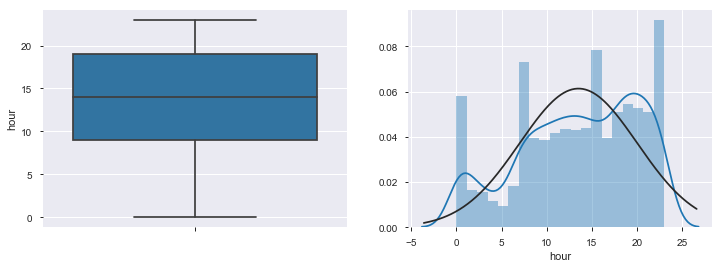

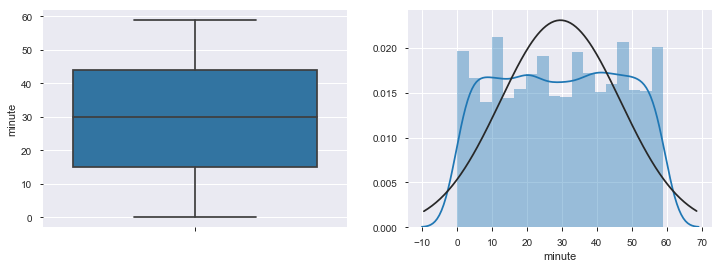

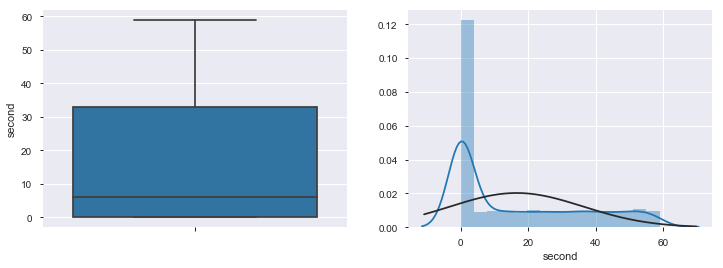

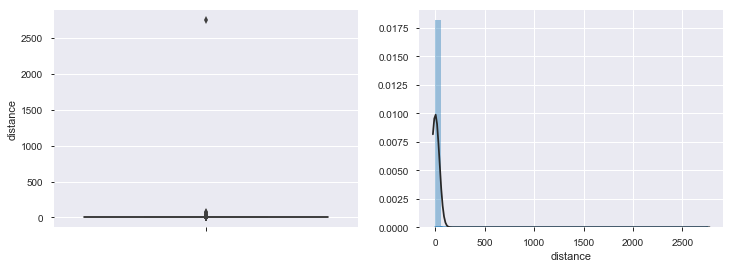

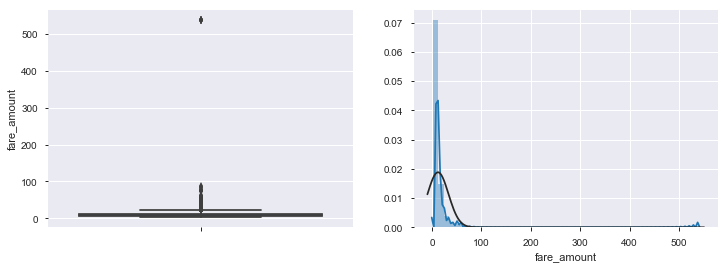

In [59]:
for col in X_test.columns:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    sns.boxplot(data=X_test,y=col,ax=ax)
    ax = fig.add_subplot(122)
    sns.distplot(X_test[col],kde=True,ax=ax, fit=stats.norm)

#Plotting the y_test data
for col in y_test.columns:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    sns.boxplot(data=y_test, y = col, ax=ax)
    ax = fig.add_subplot(122)
    sns.distplot(y_test[col], kde=True, ax=ax, fit=stats.norm)

***Fixing the outliers***
First we tried capping with the IQR range, we did not have much success since negative values were not fixed in the <b>fare_amount</b>.
We tried fixing the values <q5 and >q95 quartiles of the distribution and the negatives values were fixed in the <b>fare_amount</b> and also <b>passenger_count</b> showed good results in bringing the values to sensible range in the cab ride. For fixing the <b>distance</b> we are looking to accomodate high variability in the data and looking for quartile range between [1,99]

***Remove Outliers***
Since experimenting of fixing outliers did not work well, we will remove outliers from the data

In [ ]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
y_train_copy = y_train.copy()
y_test_copy = y_test.copy()

In [61]:
q1,q99 = np.percentile(X_train['distance'],[1,99])
entries = X_train[(X_train['distance'] < q1) | (X_train['distance'] > q99)]
X_train.drop(entries.index, axis = 0, inplace=True)
y_train.drop(entries.index, axis = 0, inplace=True)

entries_test = X_test[(X_test['distance'] < q1) | (X_test['distance'] > q99)]
X_test.drop(entries_test.index, axis = 0, inplace=True)
y_test.drop(entries_test.index, axis = 0, inplace=True)

q1,q99 = np.percentile(y_train['fare_amount'],[1,99])
entries = y_train[(y_train['fare_amount'] < q1) | (y_train['fare_amount'] >q99)]
y_train.drop(entries.index, axis = 0, inplace=True)
X_train.drop(entries.index, axis = 0, inplace=True)

entries_test = y_test[(y_test['fare_amount'] < q1) | (y_test['fare_amount'] >q99)]
X_test.drop(entries_test.index, axis = 0, inplace=True)
y_test.drop(entries_test.index, axis = 0, inplace=True)

q2,q98 = np.percentile(X_train['passenger_count'],[2,98])
entries = X_train[(X_train['passenger_count'] < q2) | (X_train['passenger_count'] > q98)]
X_train.drop(entries.index, axis = 0, inplace=True)
y_train.drop(entries.index, axis = 0, inplace=True)

entries_test = X_test[(X_test['passenger_count'] < q2) | (X_test['passenger_count'] > q98)]
X_test.drop(entries_test.index, axis = 0, inplace=True)
y_test.drop(entries_test.index, axis = 0, inplace=True)

C:\Users\gautam_pai\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [62]:
print("Number of rows dropped in X_train after outlier analysis")
print(X_train_copy.shape)
print(X_train.shape)

print("Number of rows dropped in y_train after outlier analysis")
print(y_train_copy.shape)
print(y_train.shape)

print("Number of rows dropped in X_test after outlier analysis")
print(X_test_copy.shape)
print(X_test.shape)

print("Number of rows dropped in y_test after outlier analysis")
print(y_test_copy.shape)
print(y_test.shape)

Number of rows dropped in X_train after outlier analysis
(10905, 9)
(10457, 9)
Number of rows dropped in y_train after outlier analysis
(10905, 1)
(10457, 1)
Number of rows dropped in X_test after outlier analysis
(4674, 9)
(4497, 9)
Number of rows dropped in y_test after outlier analysis
(4674, 1)
(4497, 1)


The below section of code is for fixing outliers

#Fix for distance
q1,q99 = np.percentile(X_train['distance'],[1,99])
X_train['distance'] = np.where(X_train['distance'] > q99, q99,
                       np.where(X_train['distance'] < q1, q1, X_train['distance']))
X_test['distance'] = np.where(X_test['distance'] > q99, q99,
                       np.where(X_test['distance'] < q1, q1, X_test['distance']))
test_df['distance'] = np.where(test_df['distance'] > q99, q99,
                       np.where(test_df['distance'] < q1, q1, test_df['distance']))

#Fix for passenger_count
q2,q98 = np.percentile(X_train['passenger_count'],[2,98])
X_train['passenger_count'] = np.where(X_train['passenger_count'] > q98, q98,
                       np.where(X_train['passenger_count'] < q2, q2, X_train['passenger_count']))
X_test['passenger_count'] = np.where(X_test['passenger_count'] > q98, q98,
                       np.where(X_test['passenger_count'] < q2, q2, X_test['passenger_count']))

#There are no outliers in scoring dataset the following is dummy currently
test_df['passenger_count'] = np.where(test_df['passenger_count'] > q98, q98,
                       np.where(test_df['passenger_count'] < q2, q2, test_df['passenger_count']))

#Fix the outliers for y_train and y_test
col = 'fare_amount'
q1,q99 = np.percentile(y_train[col],[1,99])

y_train[col] = np.where(y_train[col] > q99, q99,
                       np.where(y_train[col] < q1, q1, y_train[col]))
y_test[col] = np.where(y_test[col] > q99, q99,
                       np.where(y_test[col] < q1, q1, y_test[col]))


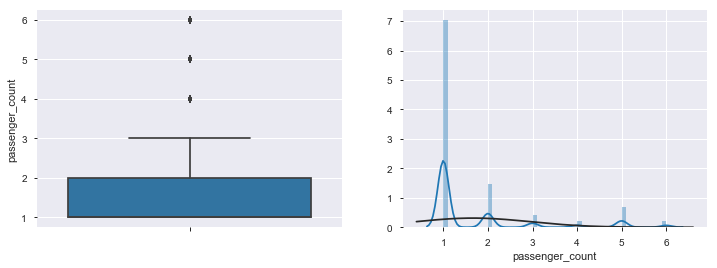

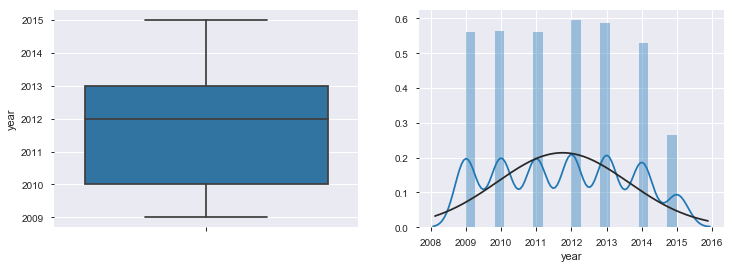

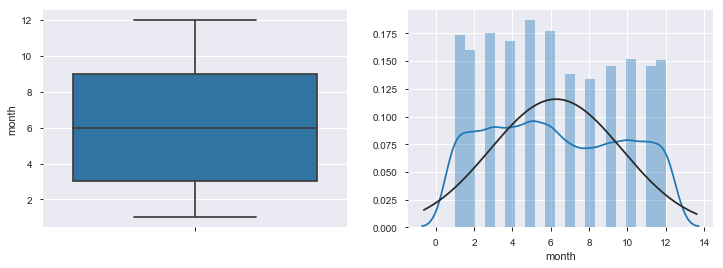

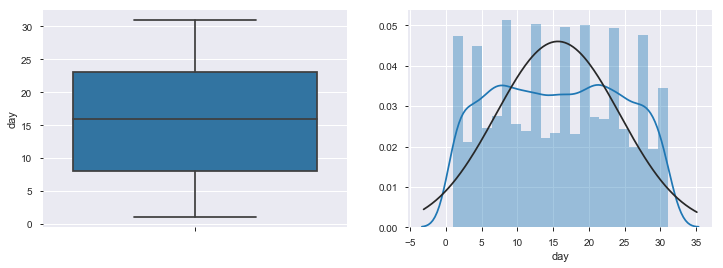

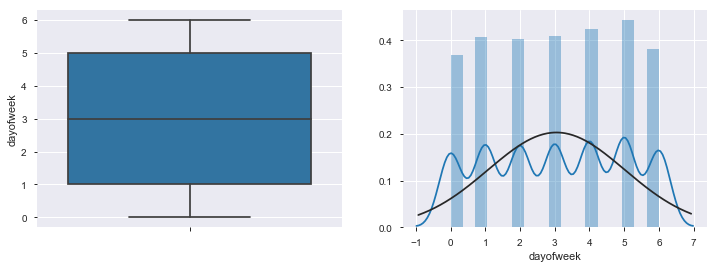

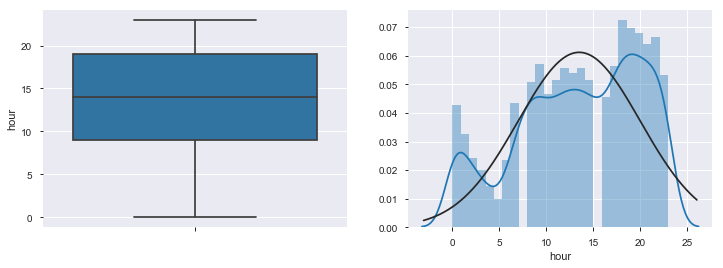

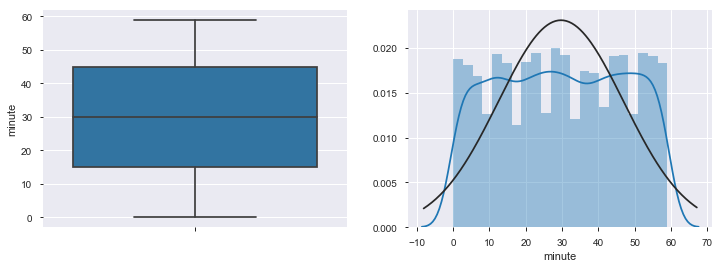

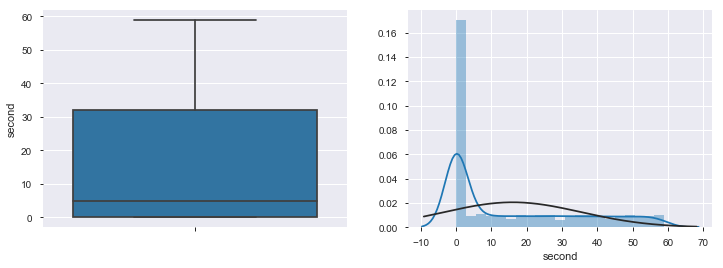

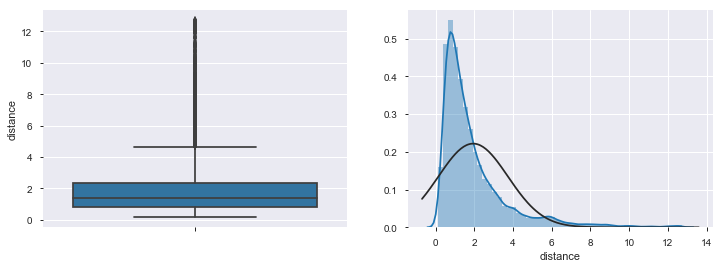

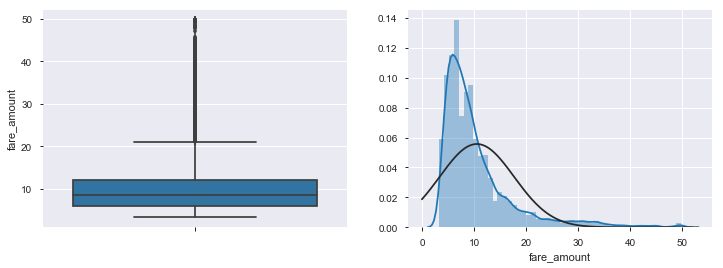

In [63]:
for col in X_train.columns:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    sns.boxplot(data=X_train,y=col,ax=ax)
    ax = fig.add_subplot(122)
    sns.distplot(X_train[col],kde=True,ax=ax, fit=stats.norm)

#Plotting the y_train data
for col in y_train.columns:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    sns.boxplot(data=y_train, y = col, ax=ax)
    ax = fig.add_subplot(122)
    sns.distplot(y_train[col], kde=True, ax=ax, fit=stats.norm)

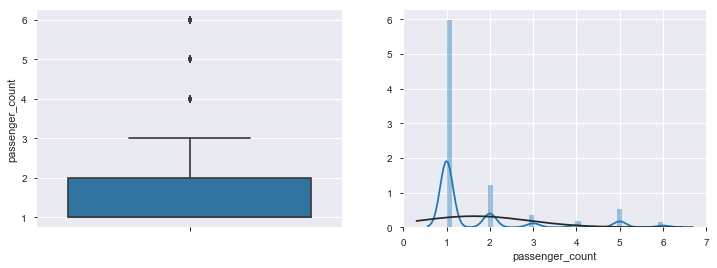

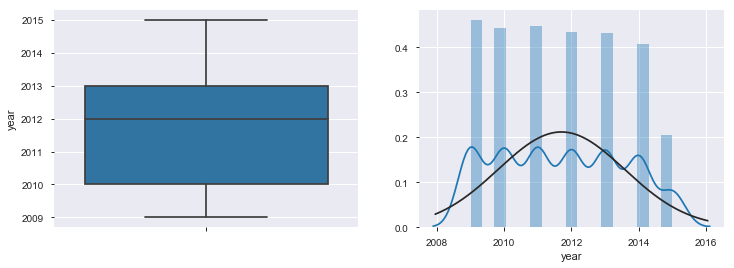

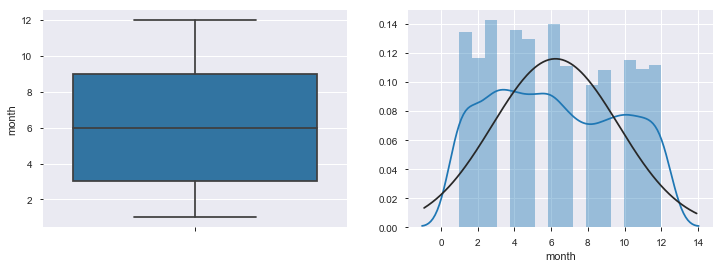

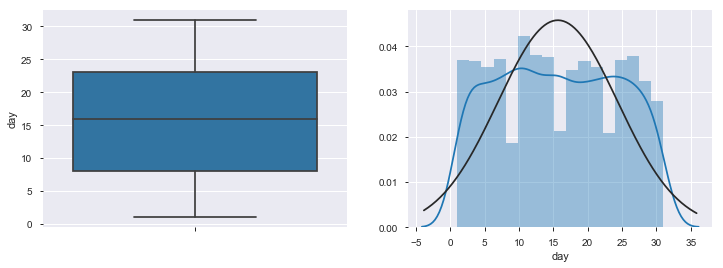

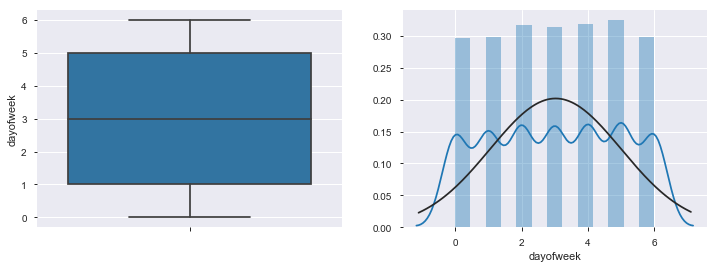

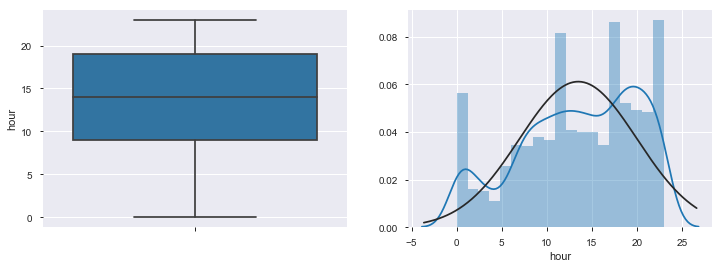

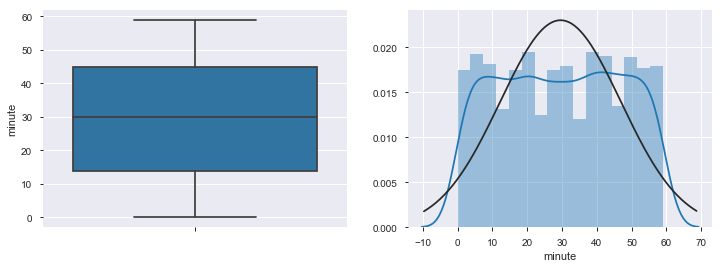

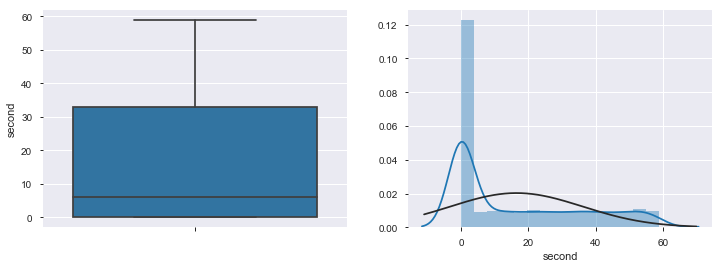

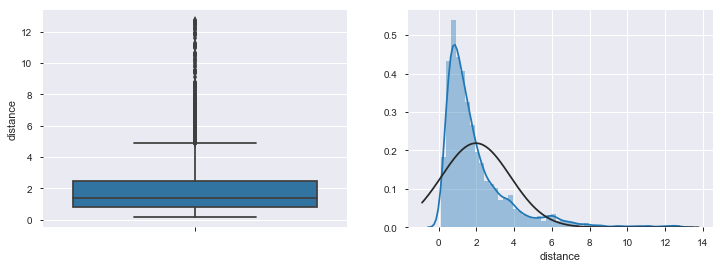

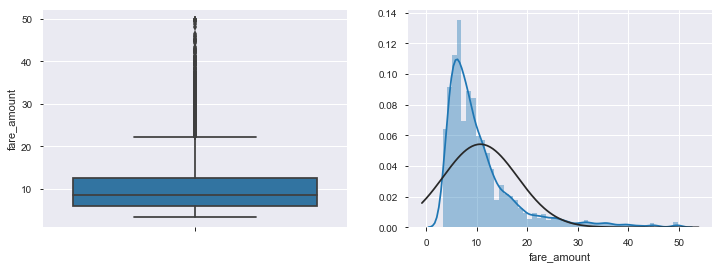

In [64]:
for col in X_test.columns:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    sns.boxplot(data=X_test,y=col,ax=ax)
    ax = fig.add_subplot(122)
    sns.distplot(X_test[col],kde=True,ax=ax, fit=stats.norm)

#Plotting the y_test data
for col in y_test.columns:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    sns.boxplot(data=y_test, y = col, ax=ax)
    ax = fig.add_subplot(122)
    sns.distplot(y_test[col], kde=True, ax=ax, fit=stats.norm)

***Lets see the distribution in the scoring set***

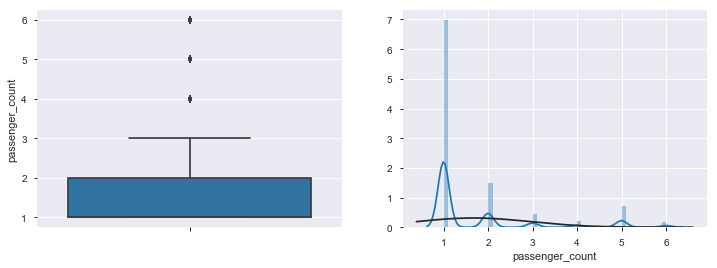

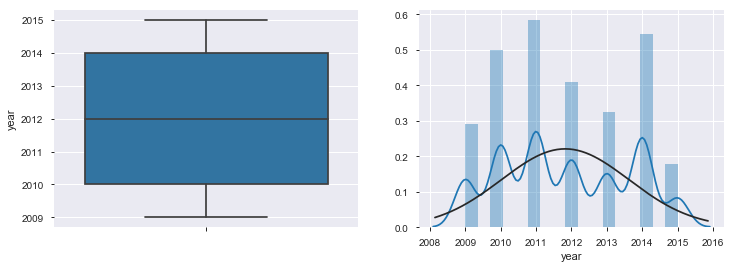

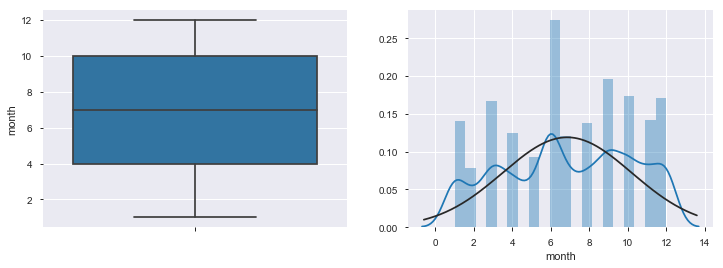

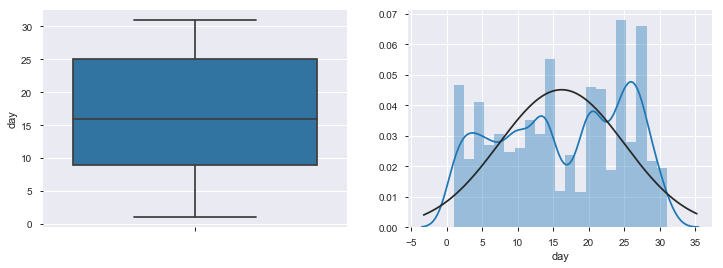

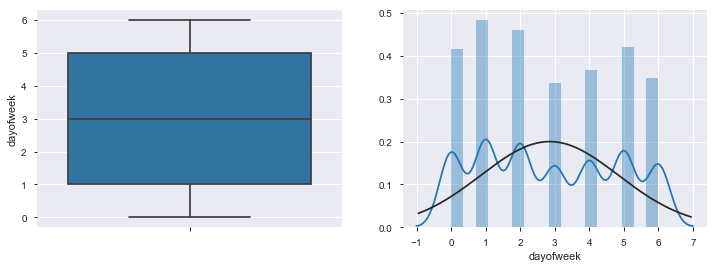

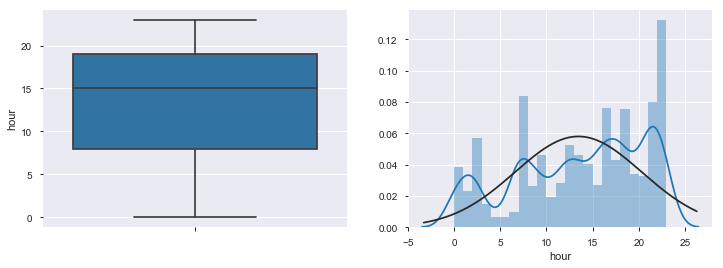

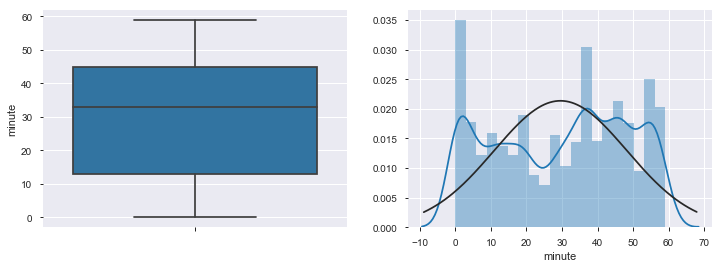

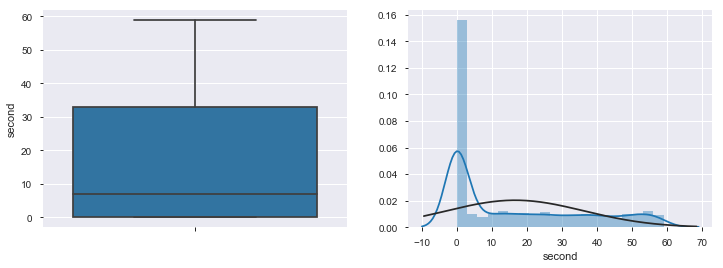

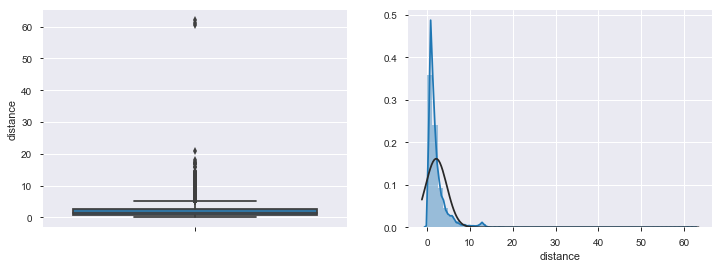

In [65]:
for col in test_df.columns:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(121)
    sns.boxplot(data=test_df,y=col,ax=ax)
    ax = fig.add_subplot(122)
    sns.distplot(test_df[col],kde=True,ax=ax, fit=stats.norm)

***MultiVariate Analysis*** by using VIF

In [66]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_train = X_train.assign(const=1)
vif = pd.DataFrame()
vif["Variables"] = X_train.columns
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

print(vif)

         Variables           VIF
0  passenger_count  1.050140e+00
1             year  1.022791e+00
2            month  1.020093e+00
3              day  1.001234e+00
4        dayofweek  1.013441e+00
5             hour  1.011937e+00
6           minute  1.001673e+00
7           second  1.056527e+00
8         distance  1.004224e+00
9            const  1.191684e+06


All the variables have VIF < 2. So multicollinearity does not exist else we had to drop the variables

In [67]:
X_train = X_train.drop("const", axis = 1)

***Correlation plots***

If we see the <b>fare_amount</b> column the influence on the dependent variable <b>fare_amount</b> is done by similar measure of <b>pickup_latitude, dropoff_latitude, pickup_longitude, dropoff_longitude </b>. Lets try deriving features from the geo coordinates to get the distance

In [68]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

In [69]:
corr = pd.concat([X_train,y_train], axis = 1).corr()
corr

,passenger_count,year,month,day,dayofweek,hour,minute,second,distance,fare_amount
passenger_count,1.000000,0.004935,0.017693,-0.001552,0.049997,0.017297,-0.021708,-0.208664,0.014309,0.023463
year,0.004935,1.000000,-0.123197,-0.022208,0.016379,-0.008007,-0.016345,0.082071,0.002853,0.119736
month,0.017693,-0.123197,1.000000,-0.019878,-0.017753,0.002998,-0.005054,-0.066417,0.021037,0.043304
day,-0.001552,-0.022208,-0.019878,1.000000,0.013259,0.000481,0.001523,-0.002786,-0.005866,-0.004554
dayofweek,0.049997,0.016379,-0.017753,0.013259,1.000000,-0.096376,0.003054,0.001985,0.026859,0.009903
hour,0.017297,-0.008007,0.002998,0.000481,-0.096376,1.000000,-0.008743,-0.002375,-0.045578,-0.025673
minute,-0.021708,-0.016345,-0.005054,0.001523,0.003054,-0.008743,1.000000,-0.000516,-0.028106,-0.027631
second,-0.208664,0.082071,-0.066417,-0.002786,0.001985,-0.002375,-0.000516,1.000000,0.007419,0.003493
distance,0.014309,0.002853,0.021037,-0.005866,0.026859,-0.045578,-0.028106,0.007419,1.000000,0.888810
fare_amount,0.023463,0.119736,0.043304,-0.004554,0.009903,-0.025673,-0.027631,0.003493,0.888810,1.000000


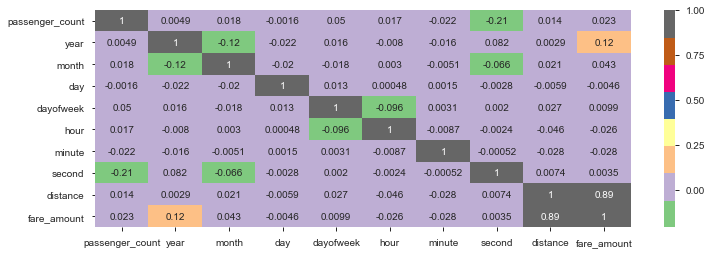

In [70]:
plt.figure(figsize=(12,4))
sns.heatmap(corr, cmap = "Accent", annot=True)

From the correlation plot, the features that are explaining the target variable **fare_amount** are <b> distance and year </b>. The rest of the features are not contributing much to the response variable **fare_amount**

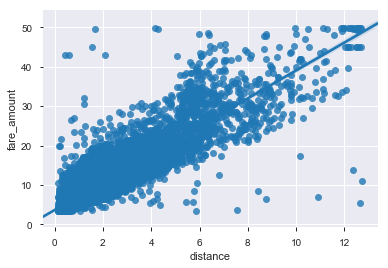

In [71]:
sns.regplot(x="distance", y="fare_amount", data = pd.concat([X_train,y_train[X_train.distance<15]], axis = 1))

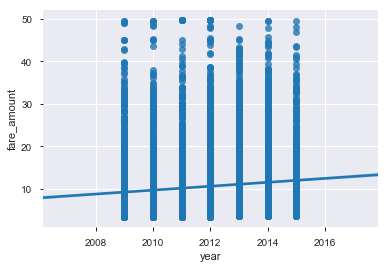

In [72]:
sns.regplot(x="year", y="fare_amount", data = pd.concat([X_train,y_train], axis = 1))

In [73]:
X_train.to_csv("CleansedData\Xtrain.csv")
X_test.to_csv("CleansedData\Xtest.csv")
y_train.to_csv("CleansedData\ytrain.csv")
y_test.to_csv("CleansedData\ytest.csv")

***Model*** <br>
Based on the analysis above from the correlation plots, I start with the following model:<br>

  **fare ~ distance, year**

In [74]:
features = ['distance','year']

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

model_lin = Pipeline((    
    ("minmax_scaler", MinMaxScaler()),
    ("lin_reg", LinearRegression())
))
model_lin.fit(X_train[features], y_train)

Pipeline(memory=None,
         steps=[('minmax_scaler',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [76]:
model_lin["lin_reg"].coef_,model_lin["lin_reg"].intercept_

(array([[44.61261959,  2.70303186]]), array([2.91153137]))

In [85]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(y_train_pred - y_train)

array([2.03441861])

In [83]:
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
def print_evaluation_metrics(y_true,y_pred):
    mae = np.mean(np.abs(y_true-y_pred))
    print("Mean Absolute Error", mae)
    mape = np.mean(np.abs(y_true-y_pred/y_true)*100) 
    print("MAPE:{}".format(mape))
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    print("Root mean squared error", rmse)
    evs = explained_variance_score(y_true,y_pred)
    print("Explained variance score", evs)
    r2score = r2_score(y_true,y_pred)
    print("R2 score is", r2score)

In [84]:
#Predicting on the training set
y_train_pred = model_lin.predict(X_train[features])

print("Training metrics")
print("------------------------")
print_evaluation_metrics(y_train.values,y_train_pred)

Training metrics
------------------------
Mean Absolute Error 1.9493990430087453
MAPE:944.4989751576834
Root mean squared error 3.1744632647606505
Explained variance score 0.8037194427190775
R2 score is 0.8037194427190775


In [280]:
model_lin["lin_reg"].score(X_train[features],y_train_pred)

-739591.0339802732

Very worst possible score. Ideal value should be 1

In [314]:
y_test_pred = model_lin.predict(X_test[features])

print("Testing metrics")
print("------------------------")
print_evaluation_metrics(y_test.values,y_test_pred)

Testing metrics
------------------------
Mean Absolute Error 2.0597163234663323
MAPE:969.1555680428363
Root mean squared error 3.424978856039606
Explained variance score 0.7837450903664309
R2 score is 0.7835223982136275


***Residual Analysis***

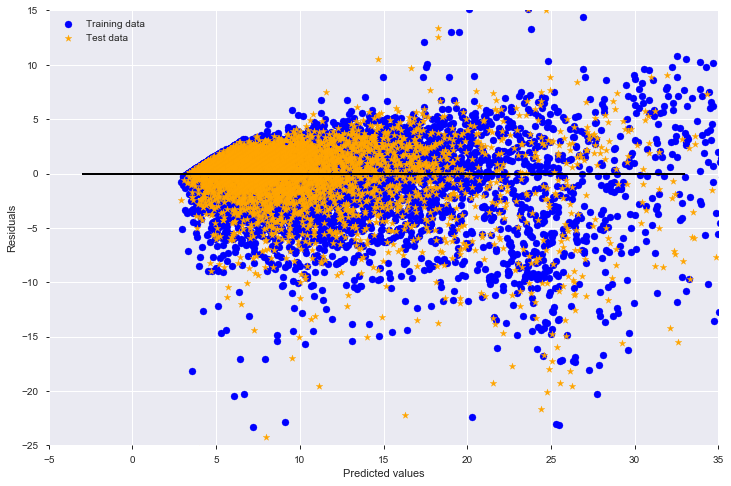

In [282]:
plt.figure(figsize=(12,8))
plt.scatter(y_train_pred, y_train_pred - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, c='orange', marker='*', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-3, xmax=33, lw=2, color='k')
plt.xlim([-5, 35])
plt.ylim([-25, 15])
plt.show()

In [310]:
from sklearn.linear_model import Ridge

model_ridge = Pipeline((    
    ("minmax_scaler", MinMaxScaler()),
    ("ridge_reg", Ridge())
))
model_ridge.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('minmax_scaler',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('ridge_reg',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [311]:
y_pred_ridge = model_ridge.predict(X_train)

print_evaluation_metrics(y_train.values, y_pred_ridge)

Mean Absolute Error fare_amount    1.941621
dtype: float64
MAPE:fare_amount    944.466786
dtype: float64
Root mean squared error 3.156951732379051
Explained variance score 0.8058789844613459
R2 score is 0.8058789844613459


In [315]:
y_test_ridge = model_ridge.predict(X_test)

print_evaluation_metrics(y_test.values, y_test_ridge)

Mean Absolute Error 2.0623700761087185
MAPE:969.132154422271
Root mean squared error 3.4179952724122873
Explained variance score 0.7846490250136857
R2 score is 0.7844043003906904


***Decision Trees***

In [286]:
from sklearn.tree import DecisionTreeRegressor
dtree_model = DecisionTreeRegressor(max_depth=6,min_samples_split=2)
dtree_model.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

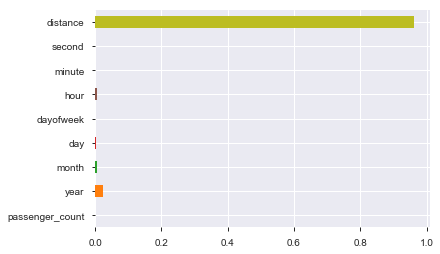

In [287]:
feat_importances = pd.Series(dtree_model.feature_importances_, index=X_train.columns)
feat_importances.plot(kind='barh')

In [288]:
y_train_pred_dtree = dtree_model.predict(X_train)

print("Training Metrics with Decision Trees")
print("---------------------------------------------")
print_evaluation_metrics(y_train['fare_amount'],y_train_pred_dtree)

Training Metrics with Decision Trees
---------------------------------------------
Mean Absolute Error 1.8008618009167132
MAPE 945.0687197113023
Root mean squared error 2.8766219738834695
Explained variance score 0.8388233005522467
R2 score is 0.8388233005522467


In [289]:
y_test_pred_dtree = dtree_model.predict(X_test)

print("Testing Metrics with Decision Trees")
print("---------------------------------------------")
print_evaluation_metrics(y_test['fare_amount'],y_test_pred_dtree)

Training Metrics with Decision Trees
---------------------------------------------
Mean Absolute Error 2.0729278729437115
MAPE 969.233651407259
Root mean squared error 3.53478540480781
Explained variance score 0.7695760205559349
R2 score is 0.7694191240050134


***Random Forests***

In [316]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, min_samples_split=2, min_samples_leaf=4, max_depth=9)
rf.fit(X_train,y_train)

C:\Users\gautam_pai\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [317]:
for name, importance in zip(X_train.columns, rf.feature_importances_):
    print(name, "=", importance)

passenger_count = 0.002157798093172853
year = 0.02801322302104799
month = 0.008506485710570878
day = 0.00762242212317536
dayofweek = 0.005057571352178831
hour = 0.016896884097135034
minute = 0.008233753109633226
second = 0.005016249739945199
distance = 0.9184956127531406


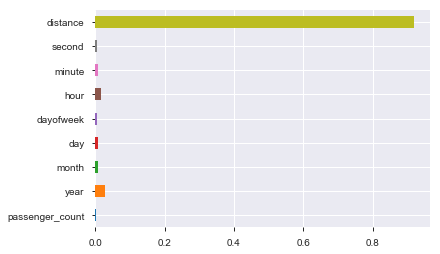

In [318]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.plot(kind='barh')

In [319]:
y_train_pred_rf = rf.predict(X_train)

print("Training Metrics with Random Forests")
print("---------------------------------------------")
print_evaluation_metrics(y_train['fare_amount'],y_train_pred_rf)

Training Metrics with Random Forests
---------------------------------------------
Mean Absolute Error 1.5236488319989174
MAPE:945.607680677631
Root mean squared error 2.4197704927651635
Explained variance score 0.8859533262262905
R2 score is 0.8859526958280752


In [294]:
y_test_pred_rf = rf.predict(X_test)

print("Testing Metrics with Random Forests")
print("---------------------------------------------")
print_evaluation_metrics(y_test['fare_amount'],y_test_pred_rf)

Testing Metrics with Random Forests
---------------------------------------------
Mean Absolute Error 1.9563947761321479
MAPE 969.4331434460107
Root mean squared error 3.2993783928641376
Explained variance score 0.7992404149699512
R2 score is 0.7991085606433806


***Residual Analysis***

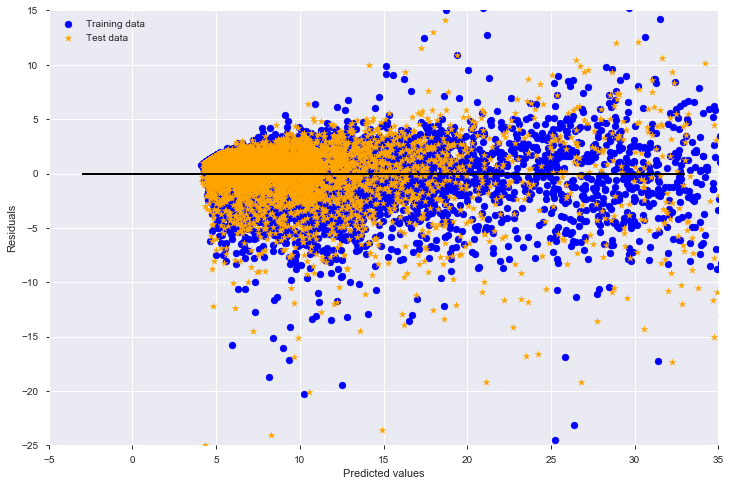

In [295]:
plt.figure(figsize=(12,8))
plt.scatter(y_train_pred_rf.reshape(-1,1), y_train_pred_rf.reshape(-1,1) - y_train, c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred_rf.reshape(-1,1), y_test_pred_rf.reshape(-1,1) - y_test, c='orange', marker='*', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-3, xmax=33, lw=2, color='k')
plt.xlim([-5, 35])
plt.ylim([-25, 15])
plt.show()

In [296]:
np.column_stack([y_test.values,y_test_pred_rf])[0:10]

array([[11.7       , 10.05885919],
       [ 6.5       ,  9.72958908],
       [10.        ,  8.63456495],
       [ 7.5       ,  7.17529013],
       [ 9.7       , 10.85866824],
       [ 5.7       ,  5.85011574],
       [10.        , 11.21263023],
       [ 4.5       ,  5.55316904],
       [30.67      , 10.5280502 ],
       [ 7.        ,  8.50912324]])

In [297]:
np.column_stack([y_test.values, y_test_pred])[0:10]

array([[11.7       , 10.2381587 ],
       [ 6.5       ,  9.58540948],
       [10.        ,  8.04809978],
       [ 7.5       ,  7.50130876],
       [ 9.7       , 11.71642042],
       [ 5.7       ,  6.48299951],
       [10.        , 10.39322493],
       [ 4.5       ,  4.98289794],
       [30.67      , 11.12418134],
       [ 7.        ,  9.50269765]])

**Submit the predictions in the scoring file**

test_df["distance"] = test_df.apply(calculate_distance, axis = 1)
test_df = test_df.drop(["pickup_latitude","pickup_longitude","dropoff_latitude","dropoff_longitude"], axis = 1)

In [ ]:
test_df.to_csv("test/test_preprocessed.csv")

In [ ]:
predicted_fare_amount = rf.predict(test_df)

In [ ]:
df_test = df_test.assign(fare_amount = predicted_fare_amount)

In [ ]:
df_test.to_csv("test/test_forecasted.csv")

***Save the Model***

In [ ]:
joblib.dump(rf, "Cab_Fare_Prediction_RF.pkl")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~***END***~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~